In [1]:
# pip install -U langgraph langsmith

In [3]:
# %pip install -qU langchain-ollama

In [4]:
BASE_URL = "https://ollama.khawasprasiddha.fun/"

In [12]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="gemma3:4b",
    temperature=0,
    base_url=BASE_URL,
    max_tokens=100,
    # other params...
)

In [14]:
## time
import requests
import json

base_url = "http://ollama.khawasprasiddha.fun"
endpoint = "/api/generate"

payload = {
    "model": "gemma3:4b",
    "prompt": "write me a 500 word essay on nepal"
}

try:
    with requests.post(base_url + endpoint, json=payload, stream=True) as response:
        response.raise_for_status()
        print("Response:", end=" ", flush=True)
        for line in response.iter_lines():
            if line:
                data = json.loads(line.decode('utf-8'))
                print(data.get("response", ""), end="", flush=True)
        print()  # Newline at the end
except requests.exceptions.RequestException as e:
    print("Error:", e)

Response: Okay, here’s a 500-word essay on Nepal, aiming for a balance of historical, geographical, and cultural elements:

---

**Nepal: A Land of Giants and Spirituality**

Nepal, a small, landlocked nation nestled in the heart of the Himalayas, is a country of breathtaking beauty, profound spirituality, and a resilient people. Often defined by its towering peaks, including the world’s highest, Mount Everest, Nepal offers a travel experience unlike any other, steeped in ancient traditions and a palpable sense of serenity. Its significance extends far beyond its stunning landscapes; it represents a crossroads of cultures, a refuge for devout Buddhists and Hindus, and a nation grappling with the challenges of modernity while fiercely preserving its heritage.

Geographically, Nepal is a dramatic masterpiece sculpted by tectonic forces. The High Himalayas dominate the landscape, forming a formidable barrier that has profoundly shaped the country's climate, culture, and economy. The ferti

KeyboardInterrupt: 

In [ ]:
for chunk in llm.stream(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]},
    stream_mode="updates"
):
    print(chunk)
    print("\n")

In [21]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


In [ ]:


class State(TypedDict):
  topic: str
  joke: str


def refine_topic(state: State):
    return {"topic": state["topic"] + " and cats"}


def generate_joke(state: State):
    llm.invoke(
        {"messages": [{"role": "user", "content": f"Write a joke about {state['topic']}"}]},
        stream_mode="updates"
    )
    return {"joke": f"This is a joke about {state['topic']}"}

graph = (
  StateGraph(State)
  .add_node(refine_topic)
  .add_node(generate_joke)
  .add_edge(START, "refine_topic")
  .add_edge("refine_topic", "generate_joke")
  .add_edge("generate_joke", END)
  .compile()
)

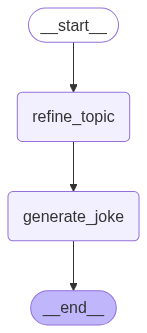

In [23]:
display(graph)

In [25]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    stream_mode="updates",
):
    print(chunk)

{'refine_topic': {'topic': 'ice cream and cats'}}
{'generate_joke': {'joke': 'This is a joke about ice cream and cats'}}


In [ ]:
import asyncio
import uuid
from datetime import datetime

# ------------------------------------------------------------------------
# HIGH-LEVEL IMPORTS (assume these packages exist in your environment)
# ------------------------------------------------------------------------

# ChatOllamaClient: wraps calls to Gemma 3.4B (or similar) via Ollama
from chatollama import ChatOllamaClient

# LangGraphAssistant: a prebuilt LangGraph interface that does:
#  - categorize requests
#  - assess security
#  - generate an action plan (list of ActionNode dataclasses)
#  - (optionally) execute approved actions via an abstract "toolkit"
from langgraph import LangGraphAssistant, ActionNode, ActionType, SecurityLevel

# Toolkit: a bundled set of “mock” or real integrations for YouTube, SMS, rides, banking, form-filling, etc.
# Each method returns a dict with { "status": "success"/"error", ... }.
from toolkit import Toolkit

# ------------------------------------------------------------------------
# MAIN “APPLICATION” CODE
# ------------------------------------------------------------------------

class DailyActivityAssistant:
    def __init__(self):
        # 1) ChatOllamaClient wraps Gemma 3.4B calls; no need to reimplement generate()
        self.llm = ChatOllamaClient(model_name="gemma:3.4b")

        # 2) LangGraphAssistant encapsulates the entire analysis + plan generation logic.
        #    You simply pass user_text and the LLM client, and it returns categories/security/actions.
        self.langgraph = LangGraphAssistant(llm_client=self.llm)

        # 3) Toolkit holds actual implementations for YouTube, Spotify, SMS, WhatsApp, ride booking, banking, etc.
        self.tools = Toolkit()

        # In-memory “storage” for conversation logs and action plans (just a dict in this example).
        self.memory = {
            "conversation_history": [],
            "action_plans": {},       # plan_id → List[ActionNode]
            "execution_history": []   # logs of executed actions
        }

    def log_conversation(self, role: str, message: str):
        self.memory["conversation_history"].append({
            "timestamp": datetime.utcnow(),
            "role": role,
            "message": message
        })

    async def run(self):
        print("🚀 Gemma 3.4B LangGraph Daily Assistant (v2 – abstracted)")
        print("=" * 50)

        while True:
            user_input = input("\n🎯 Your request (or type 'exit' to quit): ").strip()
            if not user_input or user_input.lower() in {"quit", "exit", "q"}:
                print("👋 Goodbye!")
                return

            # Log user message
            self.log_conversation("user", user_input)

            # ------------------------------------------------------------
            # Step 1: ANALYZE + CATEGORIZE + ASSESS SECURITY
            # ------------------------------------------------------------
            print("\n🔍 Analyzing your request via LangGraphAssistant...")
            analysis = await self.langgraph.analyze(user_input)
            # analysis is a dict like:
            # {
            #   "category": ActionType.MEDIA_PLAY,
            #   "security_level": SecurityLevel.LOW,
            #   "requires_confirmation": False,
            #   "raw_llm_analysis": "...Gemma's text output..."
            # }

            print(f"  • Category:      {analysis['category'].value}")
            print(f"  • Security (LSL): {analysis['security_level'].value}")
            print(f"  • Needs confirm: {analysis['requires_confirmation']}")

            # ------------------------------------------------------------
            # Step 2: GENERATE a DETAILED ACTION PLAN
            # ------------------------------------------------------------
            print("\n⚙️  Generating action plan via LangGraphAssistant...")
            plan_id = str(uuid.uuid4())
            action_nodes = await self.langgraph.generate_action_plan(user_input, analysis)

            # Store the plan
            self.memory["action_plans"][plan_id] = action_nodes

            # ------------------------------------------------------------
            # Step 3: DISPLAY PLAN & HUMAN-IN-THE-LOOP VALIDATION
            # ------------------------------------------------------------
            self._display_action_plan(action_nodes, plan_id)

            approved_actions = self._get_user_approval(action_nodes)
            if not approved_actions:
                print("\n❌ No actions approved. Returning to main prompt.")
                continue

            # ------------------------------------------------------------
            # Step 4: EXECUTE APPROVED ACTIONS
            # ------------------------------------------------------------
            print(f"\n🚀 Executing {len(approved_actions)} approved action(s)...")
            for action in approved_actions:
                print(f"\n▶️  Executing: {action.name} (Type={action.type.value})")
                result = await self._execute_action(action)
                timestamp = datetime.utcnow()

                # Log execution
                self.memory["execution_history"].append({
                    "plan_id": plan_id,
                    "action_id": action.id,
                    "action_name": action.name,
                    "timestamp": timestamp,
                    "result": result
                })

                if result.get("status") == "success":
                    print(f"   ✅ {action.name} completed successfully.")
                    if result.get("details"):
                        print(f"      Details: {result['details']}")
                else:
                    print(f"   ❌ {action.name} failed: {result.get('error', '<unknown>')}")

                # (Optional) small pause between actions
                await asyncio.sleep(0.3)

            print("\n🎉 All approved actions processed!\n")

    def _display_action_plan(self, actions: list[ActionNode], plan_id: str):
        print("\n🤖 Generated Action Plan:")
        print("=" * 60)
        for idx, action in enumerate(actions, start=1):
            # Simple icons for each security level
            sec_icon = {
                SecurityLevel.LOW: "🟢",
                SecurityLevel.MEDIUM: "🟡",
                SecurityLevel.HIGH: "🟠",
                SecurityLevel.CRITICAL: "🔴"
            }[action.security_level]

            sens_icon = "🔒" if action.sensitive_data else "🔓"
            conf_icon = "⚠️" if action.requires_confirmation else "✅"

            print(f"\n {idx}. {action.name}")
            print(f"    • Description:   {action.description}")
            print(f"    • Category:      {action.type.value}")
            print(f"    • Security:      {sec_icon} {action.security_level.value.upper()}")
            print(f"    • Sensitive:     {sens_icon} {'Yes' if action.sensitive_data else 'No'}")
            print(f"    • Confirmation:  {conf_icon} {'Required' if action.requires_confirmation else 'Not Required'}")
            print(f"    • Parameters:    {action.parameters}")
            if action.dependencies:
                print(f"    • Depends on:    {action.dependencies}")

    def _get_user_approval(self, actions: list[ActionNode]) -> list[ActionNode]:
        """Walk through each action, ask the user to Approve/Edit/Skip/Quit."""
        approved = []
        print("\n👤 Human-in-the-Loop Validation:")
        for action in actions:
            while True:
                prompt = (
                    f"\n🤔 Action: {action.name}\n"
                    f"   Description: {action.description}\n"
                    f"   Security Level: {action.security_level.value.upper()}\n"
                )
                if action.security_level in (SecurityLevel.HIGH, SecurityLevel.CRITICAL):
                    prompt += "   ⚠️  HIGH-SECURITY operation! Review carefully.\n"
                if action.sensitive_data:
                    prompt += "   🔒  Contains sensitive data.\n"

                prompt += "   [A]pprove / [E]dit / [S]kip / [Q]uit: "
                choice = input(prompt).strip().lower()

                if choice == "a":
                    action.approved = True
                    approved.append(action)
                    print("   ✅ Approved.")
                    break

                elif choice == "e":
                    edited = self._edit_action(action)
                    if edited:
                        edited.approved = True
                        approved.append(edited)
                        print("   ✅ Edited & Approved.")
                        break

                elif choice == "s":
                    print("   ⏭️  Skipped.")
                    break

                elif choice == "q":
                    print("   ❌ User requested to quit validation.")
                    return []

                else:
                    print("   ❓ Please enter A, E, S, or Q.")

        return approved

    def _edit_action(self, action: ActionNode) -> ActionNode | None:
        """Allow user to rename or re-describe an action (parameters only if not sensitive)."""
        print(f"\n✏️  Editing action '{action.name}':")

        new_name = input(f"   • Name [{action.name}]: ").strip()
        if new_name:
            action.name = new_name

        new_desc = input(f"   • Description [{action.description}]: ").strip()
        if new_desc:
            action.description = new_desc

        # If it’s not marked as “sensitive,” allow parameter tweaks
        if not action.sensitive_data:
            print("   • Current parameters:")
            for (k, v) in action.parameters.items():
                new_v = input(f"       {k} [{v}]: ").strip()
                if new_v:
                    action.parameters[k] = new_v

        return action

    async def _execute_action(self, action: ActionNode) -> dict:
        """
        Dispatch to the correct Toolkit method based on action.type.
        Toolkit should know how to call YouTube, Spotify, ride-booking, banking, etc.
        Return a dict { "status": "success"/"error", ... }.
        """
        t = action.type
        p = action.parameters

        try:
            if t == ActionType.MEDIA_PLAY:
                # We assume parameters might include "app": "youtube" or "spotify", plus "query" or "track"
                if p.get("app") == "youtube":
                    return self.tools.youtube_search(p["query"])
                elif p.get("app") == "spotify":
                    return self.tools.spotify_play(p["track"], p.get("artist"))
                else:
                    # generic media play fallback
                    return {"status": "error", "error": "Unknown media platform"}

            elif t == ActionType.COMMUNICATION:
                if p.get("type") == "sms":
                    return self.tools.send_sms(p["recipient"], p["message"])
                elif p.get("platform") == "whatsapp":
                    return self.tools.whatsapp_send(p["contact"], p["message"])
                elif p.get("type") == "voice_call":
                    return self.tools.make_phone_call(p["number"])
                else:
                    return {"status": "error", "error": "Unknown communication subtype"}

            elif t == ActionType.TRANSPORTATION:
                # We expect a sequence: open app → set pickup → set destination → book_ride
                if p.get("action") == "book_ride":
                    return self.tools.book_ride(p["pickup"], p["destination"], p.get("service"))
                else:
                    # For “open app”, “set pickup”, “set destination” steps,
                    # we can return a quick “success” since actual data is saved for the final step.
                    return {"status": "success", "details": f"{action.name} done."}

            elif t == ActionType.FINANCIAL:
                # Steps: open banking → authenticate → initiate topup → confirm transaction
                if action.name.lower().startswith("authenticate"):
                    return {"status": "success", "details": "Authenticated via PIN/biometric."}
                elif action.name.lower().startswith("initiate"):
                    return self.tools.mobile_banking_topup(
                        account=p["account_type"],
                        amount=p["amount"],
                        pin=p.get("pin", "")  # pin might be collected out-of-band
                    )
                elif action.name.lower().startswith("confirm"):
                    return {"status": "success", "details": "OTP confirmed. Transaction complete."}
                else:
                    return {"status": "success", "details": f"{action.name} done."}

            elif t == ActionType.DATA_ENTRY:
                # Fill forms in sequential steps. In a true implementation, you'd carry forward the “form_data”
                if action.name.lower().startswith("open form"):
                    return {"status": "success", "details": "Form opened."}
                elif action.name.lower().startswith("fill"):
                    return self.tools.fill_share_details(p["fields"])
                elif action.name.lower().startswith("review"):
                    return {"status": "success", "details": "Form reviewed & submitted."}
                else:
                    return {"status": "error", "error": "Unknown data entry step"}

            else:
                # Fallback for SYSTEM_CONTROL or WEB_SEARCH
                # If it’s “WEB_SEARCH,” assume toolkit has a generic “web_search” method:
                if t == ActionType.WEB_SEARCH and p.get("query"):
                    return self.tools.web_search(p["query"])
                # Otherwise, simply “acknowledge” without doing anything
                return {"status": "success", "details": "No‐op for generic/system control action."}

        except Exception as exc:
            return {"status": "error", "error": str(exc)}


# ------------------------------------------------------------------------
# ENTRY POINT
# ------------------------------------------------------------------------


ModuleNotFoundError: No module named 'chatollama'

In [ ]:

if __name__ == "__main__":
    assistant = DailyActivityAssistant()
    asyncio.run(assistant.run())
